# import


In [73]:
# 3. 能量响应分析：发射能量 vs 沉积能量
import matplotlib.pyplot as plt


# 检查 ROOT 文件中的所有分支
import uproot
import os

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import importlib
import data_loader

importlib.reload(data_loader)
from data_loader import load_and_process_data

from matplotlib.colors import LogNorm

## DataLoading

In [53]:
# 检查 ROOT 文件中的所有分支
import uproot
import os

root_file = "data/res2.root"
file = uproot.open(root_file)
tree = file["CsI"]

print("ROOT 文件中的所有分支:")
print("=" * 60)
for branch_name in tree.keys():
    branch = tree[branch_name]
    print(f"{branch_name:30s} {branch.typename}")
print("=" * 60)

ROOT 文件中的所有分支:
EventID                        int32_t
TotalEdep                      double
HitCount                       int32_t
CrystalID                      std::vector<int32_t>
CrystalEdep                    std::vector<double>
CrystalTime                    std::vector<double>
CrystalPosX                    std::vector<double>
CrystalPosY                    std::vector<double>
CrystalPosZ                    std::vector<double>
CrystalPDG                     std::vector<int32_t>
CrystalParentID                std::vector<int32_t>
CrystalDirX                    std::vector<double>
CrystalDirY                    std::vector<double>
CrystalDirZ                    std::vector<double>
CrystalKineticEnergy           std::vector<double>
CrystalProcessID               std::vector<int32_t>
PrimaryPDG                     std::vector<int32_t>
PrimaryEnergy                  std::vector<double>
PrimaryPosX                    std::vector<double>
PrimaryPosY                    std::vector<doubl

In [54]:
# 删除旧的缓存文件，以便重新生成包含所有分支的数据
import os

cache_file = "data/res2_hits.parquet"
if os.path.exists(cache_file):
    os.remove(cache_file)
    print(f"已删除旧缓存: {cache_file}")

已删除旧缓存: data/res2_hits.parquet


In [74]:
# ================== 读取与预处理数据 ==================

from data_loader import load_and_process_data

# 配置路径
root_file = "data/res2.root"
output_dir = "plots"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

try:
    # 一键加载并预处理 (会自动读取/生成 parquet 缓存)
    # 注意：现在返回 5 个值，增加了 df_primaries
    data, df_hits, df_primaries, process_map, num_events = load_and_process_data(root_file, cache=True)

    print("\nDataFrame Preview (Hits):")
    print(df_hits.head())

    print("\nDataFrame Preview (Primaries):")
    print(df_primaries.head())

    # 为了兼容后面的绘图代码，将 DataFrame 列赋值给变量
    # 注意：这里直接使用 DataFrame 的列，它们已经是 numpy array 或 Series
    flat_edep = df_hits["edep"]
    flat_time = df_hits["time"]
    flat_posX = df_hits["posX"]
    flat_posY = df_hits["posY"]
    flat_pdg = df_hits["pdg"]
    flat_process = df_hits["processID"]
    flat_id = df_hits["crystalID"]

except Exception as e:
    print(f"Error: {e}")
    import traceback

    traceback.print_exc()

[Info] Loaded 7 processes from 'data/res2_ProcessIDMap.txt'
Opening ROOT file: data/res2.root...
Successfully loaded 500000 events from ROOT.
Loading DataFrames from cache...
Loaded 1067393 hits and 1000000 primaries from cache.

DataFrame Preview (Hits):
   EventID  hit_idx      edep      time        posX        posY        posZ  \
0        0        0  0.246478  0.012446  243.500000 -217.280024  -63.638601   
1        1        0  5.926113  0.000000   -9.942948 -226.133243 -149.076349   
2        2        0  2.846352  0.000000   50.612061 -214.194216  134.017125   
3        2        1  0.510999  0.086264   77.145706 -224.374424  127.273105   
4        3        0  4.773440  0.000000  142.478758   12.545274  -14.164356   

   pdg  parentID      dirX      dirY      dirZ  kineticEnergy  processID  \
0   11         0 -0.994459 -0.066552  0.081382       0.331854          0   
1  -11         0  0.413241 -0.754058 -0.510518       2.568682          0   
2  -11         0  0.147713  0.954757  0.2

# Process

In [ ]:
# ================== 关联发射粒子与探测器 Hit ==================

# 1. 将发射粒子信息合并到 Hit 数据中
# 我们使用 EventID 作为键进行合并
# suffixes=('_hit', '_primary') 用于区分同名列 (如 pdg, posX 等)
df_merged = pd.merge(df_hits, df_primaries, on="EventID", suffixes=("_hit", "_primary"))

print("合并后的 DataFrame (前 5 行):")
# 选取一些关键列进行展示
cols_to_show = ["EventID", "edep", "pdg_hit", "parentID", "pdg_primary", "energy"]
print(df_merged[cols_to_show].head())

# 2. 区分 Hit 是由初级粒子直接产生，还是由次级粒子产生
# 在 Geant4 中，通常 ParentID = 0 表示该径迹是初级粒子
# 如果 parentID == 0，说明产生这个 Hit 的粒子就是发射的粒子本身
primary_hits = df_merged[df_merged["parentID"] == 0]
secondary_hits = df_merged[df_merged["parentID"] > 0]

print(f"\n统计信息:")
print(f"  总 Hits 数: {len(df_merged)}")
print(f"  初级粒子直接产生的 Hits: {len(primary_hits)} ({len(primary_hits) / len(df_merged):.1%})")
print(f"  次级粒子产生的 Hits: {len(secondary_hits)} ({len(secondary_hits) / len(df_merged):.1%})")

合并后的 DataFrame (前 5 行):
   EventID      edep  pdg_hit  parentID  pdg_primary    energy
0        0  0.246478       11         0           11  0.843090
1        0  0.246478       11         0          -11  0.843090
2        1  5.926113      -11         0           11  3.079680
3        1  5.926113      -11         0          -11  3.079680
4        2  2.846352      -11         0           11  1.678676

统计信息:
  总 Hits 数: 213048
  初级粒子直接产生的 Hits: 105294 (49.4%)
  次级粒子产生的 Hits: 107754 (50.6%)


: 

In [56]:
# 按 EventID 分组计算总沉积能量
event_edep = df_hits.groupby("EventID")["edep"].sum().reset_index()
event_edep.rename(columns={"edep": "total_edep"}, inplace=True)

# 合并发射能量信息
# 注意：一个事件可能有多个发射粒子，这里我们计算每个事件的总发射能量
event_primary = df_primaries.groupby("EventID")["energy"].sum().reset_index()
event_primary.rename(columns={"energy": "total_primary_energy"}, inplace=True)

# 合并两个统计结果
df_energy_corr = pd.merge(event_edep, event_primary, on="EventID")

In [57]:
df_hits

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
0,0,0,0.246478,0.012446,243.500000,-217.280024,-63.638601,11,0,-0.994459,-0.066552,0.081382,0.331854,0,70001,7,0,1
1,1,0,5.926113,0.000000,-9.942948,-226.133243,-149.076349,-11,0,0.413241,-0.754058,-0.510518,2.568682,0,30000,3,0,0
2,2,0,2.846352,0.000000,50.612061,-214.194216,134.017125,-11,0,0.147713,0.954757,0.258108,1.167677,0,40004,4,0,4
3,2,1,0.510999,0.086264,77.145706,-224.374424,127.273105,22,2,0.946232,0.031271,0.321972,0.108472,1,50004,5,0,4
4,3,0,4.773440,0.000000,142.478758,12.545274,-14.164356,-11,0,0.567180,0.542932,-0.619299,2.471743,0,60402,6,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067388,499995,0,1.869134,0.000000,-144.386486,224.240529,-120.016040,-11,0,0.925454,-0.320352,-0.202262,0.679067,0,10700,1,7,0
1067389,499996,0,0.405223,0.038438,-75.831520,-160.647334,-152.000000,11,0,-0.621200,0.492882,0.609244,0.405223,0,20100,2,1,0
1067390,499998,0,0.687879,0.000000,-102.276405,176.324268,-127.594405,-11,0,-0.376753,0.068563,-0.923773,0.016460,0,20600,2,6,0
1067391,499998,1,0.367038,0.214547,-104.655155,190.665560,-66.827243,22,2,-0.389830,0.062119,-0.918789,0.156469,1,20701,2,7,1


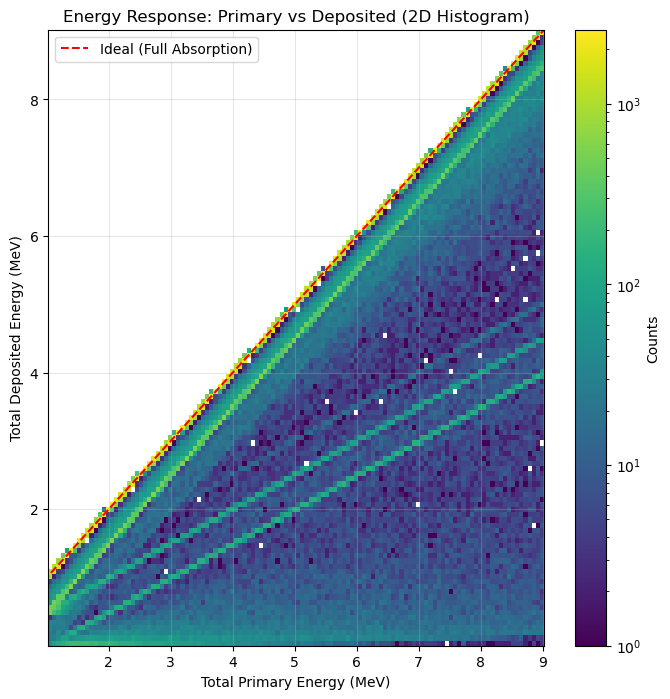

In [58]:
# 绘图 1: 能量响应二维直方图
plt.figure(figsize=(8, 8))
counts, xedges, yedges, image = plt.hist2d(
    df_energy_corr["total_primary_energy"],
    df_energy_corr["total_edep"],
    bins=(120, 120),
    norm=LogNorm(),
    cmap="viridis",
)
plt.colorbar(image, label="Counts")
# 绘制 y=x 参考线
max_e = max(df_energy_corr["total_primary_energy"].max(), df_energy_corr["total_edep"].max())
plt.plot([0, max_e], [0, max_e], "r--", label="Ideal (Full Absorption)")

plt.xlabel("Total Primary Energy (MeV)")
plt.ylabel("Total Deposited Energy (MeV)")
plt.title("Energy Response: Primary vs Deposited (2D Histogram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
pd.read_parquet("data/res2_primaries.parquet")

,EventID,primary_idx,pdg,energy,posX,posY,posZ,dirX,dirY,dirZ
0,0,0,11,0.843090,246.423384,-216.977166,-64.050394,-0.985055,-0.102050,0.138757
1,0,1,-11,0.843090,246.423384,-216.977166,-64.050394,0.985055,0.102050,-0.138757
2,1,0,11,3.079680,-9.942948,-226.133243,-149.076349,-0.413241,0.754058,0.510518
3,1,1,-11,3.079680,-9.942948,-226.133243,-149.076349,0.413241,-0.754058,-0.510518
4,2,0,11,1.678676,50.612061,-214.194216,134.017125,-0.147713,-0.954757,-0.258108
...,...,...,...,...,...,...,...,...,...,...
99995,49997,1,-11,0.652990,-246.468654,-242.817614,-136.094477,-0.395830,-0.910893,0.116589
99996,49998,0,11,1.545640,154.036942,-8.196042,-65.305403,-0.585762,-0.801052,0.123281
99997,49998,1,-11,1.545640,154.036942,-8.196042,-65.305403,0.585762,0.801052,-0.123281
99998,49999,0,11,3.243338,-27.663736,220.092665,-60.484416,0.657693,-0.223672,-0.719312


In [32]:
cache_file = "data/res2_primaries.parquet"
if os.path.exists(cache_file):
    os.remove(cache_file)
    print(f"已删除旧缓存: {cache_file}")
cache_file

已删除旧缓存: data/res2_primaries.parquet


'data/res2_primaries.parquet'

In [ ]:
res2_primaries.parquet

In [35]:
# 查看 DataFrame 的完整信息
print("\n数据集信息:")
print(f"总事件数: {num_events}")
print(f"总 Hit 数: {len(df_hits)}")
print(f"\nDataFrame 列:")
for col in df_hits.columns:
    print(f"  - {col:20s} (类型: {df_hits[col].dtype})")

print(f"\n数据统计:")
print(df_hits.describe())


数据集信息:
总事件数: 50000
总 Hit 数: 106524

DataFrame 列:
  - EventID              (类型: int64)
  - hit_idx              (类型: int64)
  - edep                 (类型: float64)
  - time                 (类型: float64)
  - posX                 (类型: float64)
  - posY                 (类型: float64)
  - posZ                 (类型: float64)
  - pdg                  (类型: int32)
  - parentID             (类型: int32)
  - dirX                 (类型: float64)
  - dirY                 (类型: float64)
  - dirZ                 (类型: float64)
  - kineticEnergy        (类型: float64)
  - processID            (类型: int32)
  - crystalID            (类型: int32)
  - ix                   (类型: int32)
  - iy                   (类型: int32)
  - iz                   (类型: int32)

数据统计:
             EventID        hit_idx           edep           time  \
count  106524.000000  106524.000000  106524.000000  106524.000000   
mean    25002.544478       0.878675       1.988909       0.097721   
std     14424.379870       1.050690       2.269432  

In [10]:
# 查看返回值的详细信息
print("=" * 60)
print("load_and_process_data() 返回值说明:")
print("=" * 60)

print("\n1. data (Awkward Array):")
print(f"   类型: {type(data)}")
print(f"   形状: {len(data)} 个事件")
print(f"   包含字段: {data.fields}")
print(f"   说明: 这是原始的 ROOT 数据，保持了事件的层次结构")
print(f"   示例: data['TotalEdep'] 是每个事件的总能量沉积")

print("\n2. df_hits (Pandas DataFrame):")
print(f"   类型: {type(df_hits)}")
print(f"   形状: {df_hits.shape} (行数 × 列数)")
print(f"   说明: 这是展平后的 Hit 级别数据，每一行代表一个 Hit")
print(f"   列名: {list(df_hits.columns)}")

print("\n3. process_map (字典):")
print(f"   类型: {type(process_map)}")
print(f"   大小: {len(process_map)} 个物理过程")
print(f"   说明: ProcessID → 过程名称的映射")
print(f"   示例: {dict(list(process_map.items())[:5])}")

print("\n4. num_events (整数):")
print(f"   类型: {type(num_events)}")
print(f"   值: {num_events}")
print(f"   说明: 总事件数")

print("\n" + "=" * 60)

load_and_process_data() 返回值说明:

1. data (Awkward Array):
   类型: <class 'awkward.highlevel.Array'>
   形状: 50000 个事件
   包含字段: ['EventID', 'TotalEdep', 'HitCount', 'CrystalID', 'CrystalEdep', 'CrystalTime', 'CrystalPosX', 'CrystalPosY', 'CrystalPosZ', 'CrystalPDG', 'CrystalParentID', 'CrystalDirX', 'CrystalDirY', 'CrystalDirZ', 'CrystalKineticEnergy', 'CrystalProcessID']
   说明: 这是原始的 ROOT 数据，保持了事件的层次结构
   示例: data['TotalEdep'] 是每个事件的总能量沉积

2. df_hits (Pandas DataFrame):
   类型: <class 'pandas.core.frame.DataFrame'>
   形状: (104850, 18) (行数 × 列数)
   说明: 这是展平后的 Hit 级别数据，每一行代表一个 Hit
   列名: ['EventID', 'hit_idx', 'edep', 'time', 'posX', 'posY', 'posZ', 'pdg', 'parentID', 'dirX', 'dirY', 'dirZ', 'kineticEnergy', 'processID', 'crystalID', 'ix', 'iy', 'iz']

3. process_map (字典):
   类型: <class 'dict'>
   大小: 5 个物理过程
   说明: ProcessID → 过程名称的映射
   示例: {0: 'Primary', 1: 'annihil', 2: 'compt', 4: 'conv', 3: 'eBrem'}

4. num_events (整数):
   类型: <class 'int'>
   值: 50000
   说明: 总事件数



In [12]:
df_hits

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
0,0,0,0.290272,0.012849,243.500000,-217.280024,-63.638601,11,0,-0.995292,-0.062191,0.074340,0.290272,0,70001,7,0,1
1,1,0,3.729834,0.000000,-16.199048,224.674826,-148.459765,-11,0,-0.892142,0.041292,-0.449863,1.609417,0,30700,3,7,0
2,2,0,6.567498,0.000000,103.964251,239.040473,-29.058119,-11,0,-0.641936,0.215979,-0.735712,3.028250,0,50702,5,7,2
3,3,0,1.496094,0.000000,-97.316725,15.587585,143.700723,-11,0,-0.434871,0.164118,0.885411,0.418953,0,20404,2,4,4
4,4,0,4.177339,0.000000,120.120463,-235.808632,-9.094943,-11,0,-0.638876,-0.679499,-0.360718,2.088669,0,50002,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104845,49998,0,3.289545,0.000000,-16.274750,153.871976,43.786372,-11,0,0.688594,-0.645357,-0.330685,1.644772,0,30603,3,6,3
104846,49998,1,0.510999,0.280818,-21.356087,92.281992,124.647650,22,2,0.807326,-0.538462,0.241420,0.272817,1,30504,3,5,4
104847,49998,2,0.510999,0.290103,-12.943968,192.667392,-34.859046,22,2,0.892319,-0.387043,0.232302,0.235411,1,30701,3,7,1
104848,49999,0,3.297206,0.000000,92.841321,-164.451023,111.037741,-11,0,0.462652,-0.762083,-0.452970,1.393104,0,50104,5,1,4


In [11]:
df_hits
event_id_counts = df_hits["EventID"].value_counts().sort_index().rename("hit_count").to_frame()
event_id_counts[event_id_counts["hit_count"] > 6]

,hit_count
EventID,
476,7
502,7
514,11
1171,8
1282,7
...,...
46459,7
48185,7
48374,8


In [92]:
df_hits[df_hits["EventID"] == 514]

,EventID,hit_idx,edep,time,posX,posY,posZ,pdg,parentID,dirX,dirY,dirZ,kineticEnergy,processID,crystalID,ix,iy,iz
1059,514,0,2.158392,0.225707,60.500000,-40.520601,-32.860805,-11,0,-0.067199,0.941348,0.330679,2.158392,0,40301,4,3,1
1060,514,1,0.296210,0.406665,61.964335,-77.752994,-8.869295,22,2,0.795128,-0.604728,-0.045561,0.296210,1,50202,5,2,2
1061,514,2,0.195359,0.377567,54.856521,-72.779330,-7.953982,11,6,-0.633634,-0.504049,0.586892,0.195359,2,40202,4,2,2
1062,514,3,0.019430,0.276466,59.027709,-47.210002,-23.684732,11,6,0.106667,0.513002,0.851734,0.019430,2,40302,4,3,2
1063,514,4,0.452671,0.728250,85.135017,61.500000,-135.536790,22,2,0.385951,0.573539,-0.722562,0.452671,1,50500,5,5,0
1064,514,5,0.031582,0.579539,70.584435,39.877249,-108.295789,11,5,-0.927275,0.290535,-0.236115,0.026919,2,50400,5,4,0
1065,514,6,0.017357,0.498138,65.893360,20.256888,-84.455478,11,5,-0.462757,0.732902,0.498708,0.017357,2,50401,5,4,1
1066,514,7,0.009389,0.335082,63.402984,-18.718985,-55.057716,11,5,0.273580,-0.591691,-0.758325,0.009389,2,50301,5,3,1
1067,514,8,0.170906,0.050128,61.500000,-120.042994,-49.317603,11,0,0.019765,-0.981013,-0.192932,2.165107,0,50201,5,2,1
1068,514,9,0.138481,0.057717,60.500000,-121.253887,-47.954044,11,0,-0.537425,-0.519159,0.664566,1.994718,0,40201,4,2,1


In [ ]:
np.sum(df_hits[df_hits["EventID"] == 514])

np.float64(5.3458323389604026)

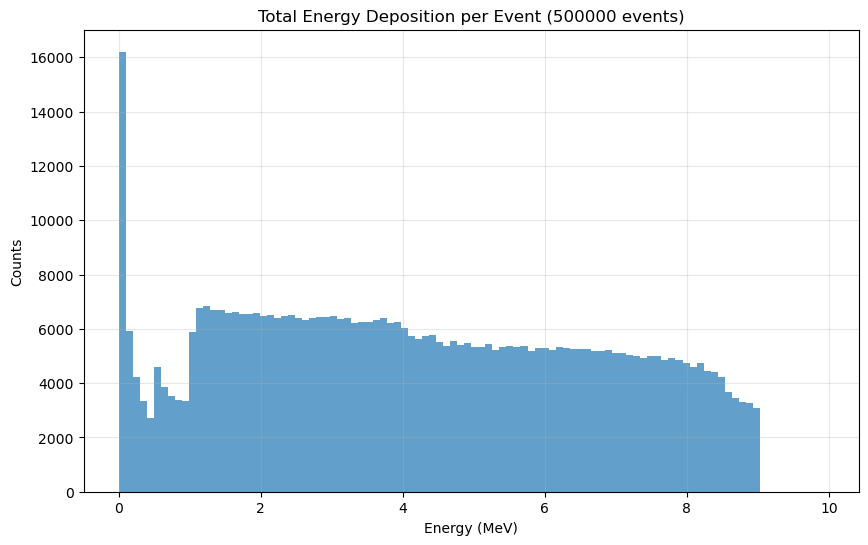

In [63]:
# ================== 绘图分析 ==================
import matplotlib.pyplot as plt

# 1. 总能量沉积谱
plt.figure(figsize=(10, 6))
plt.hist(data["TotalEdep"], bins=100, range=(0, max(data["TotalEdep"]) * 1.1), histtype="stepfilled", alpha=0.7, label="Total Edep")
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.title(f"Total Energy Deposition per Event ({num_events} events)")
plt.grid(True, alpha=0.3)
plt.show()


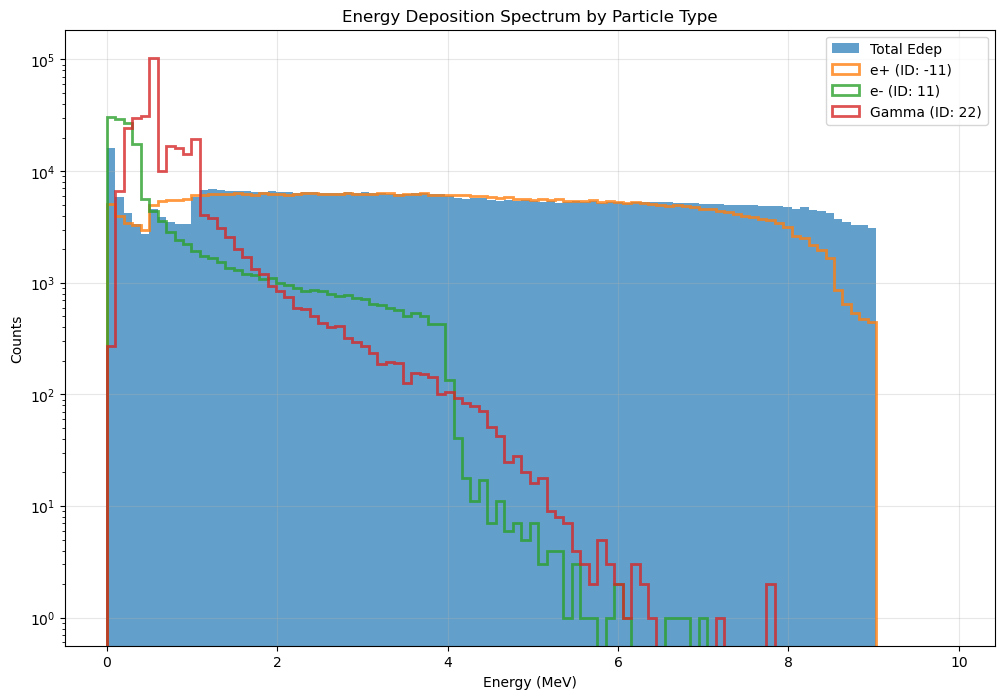

In [ ]:
# 1.1 不同粒子类型的能量沉积谱
# 我们需要将每个 Hit 的能量沉积按粒子类型分类，然后累加到每个事件中

# 获取所有唯一的粒子类型
unique_pdgs = np.unique(flat_pdg)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}

plt.figure(figsize=(12, 8))


plt.hist(data["TotalEdep"], bins=100, range=(0, max(data["TotalEdep"]) * 1.1), histtype="stepfilled", alpha=0.7, label="Total Edep")

# 遍历每种粒子类型
for pid in unique_pdgs:
    # 创建掩码：选择当前粒子类型的 Hit
    mask = data["CrystalPDG"] == pid

    # 计算该粒子类型在每个事件中的总能
plt.yscale("log")  # 使用对数坐标，因为不同粒子的贡献可能相差很大
plt.show()

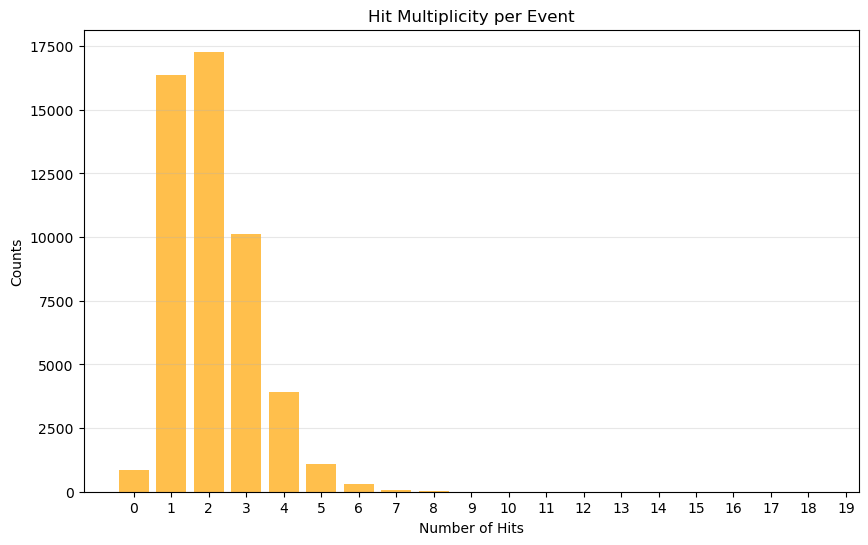

In [32]:
# 2. 击中数分布
plt.figure(figsize=(10, 6))
plt.hist(data["HitCount"], bins=range(0, 20), align="left", rwidth=0.8, color="orange", alpha=0.7)
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.title("Hit Multiplicity per Event")
plt.xticks(range(0, 20))
plt.grid(True, axis="y", alpha=0.3)
plt.show()


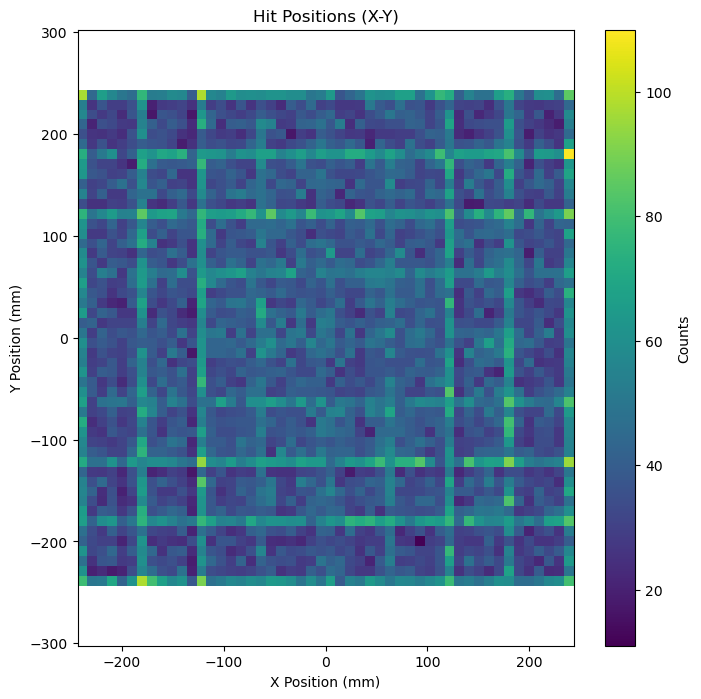

In [33]:
# 3. 击中位置分布 (Hit Positions X-Y)
plt.figure(figsize=(8, 8))
plt.hist2d(flat_posX, flat_posY, bins=50, cmap="viridis", cmin=1)
plt.colorbar(label="Counts")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.title("Hit Positions (X-Y)")
plt.axis("equal")
plt.show()


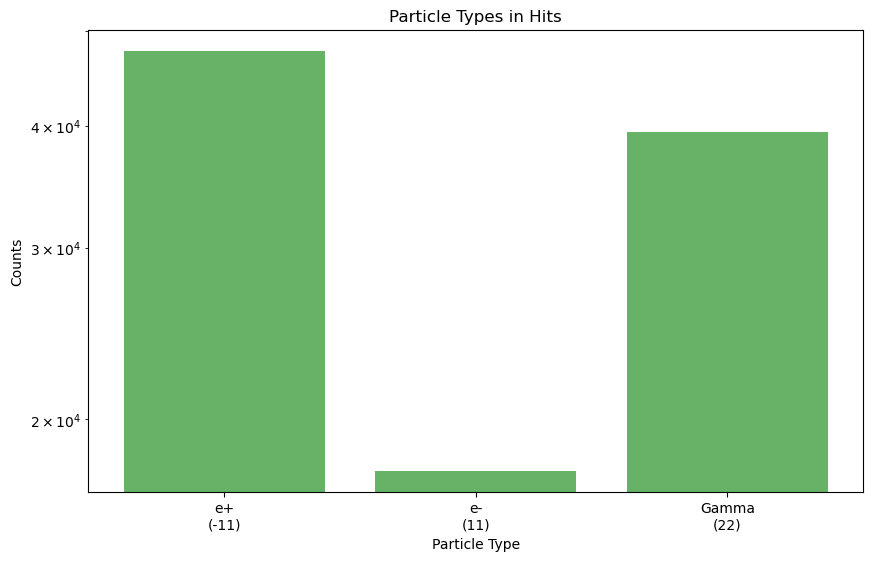

In [34]:
# 4. 粒子类型分布
unique_pdgs, counts = np.unique(flat_pdg, return_counts=True)
pdg_names = {22: "Gamma", 11: "e-", -11: "e+", 13: "mu-", -13: "mu+", 2112: "Neutron", 2212: "Proton", 1000020040: "Alpha"}
labels = [f"{pdg_names.get(pid, str(pid))}\n({pid})" for pid in unique_pdgs]

plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_pdgs)), counts, tick_label=labels, color="green", alpha=0.6)
plt.xlabel("Particle Type")
plt.ylabel("Counts")
plt.title("Particle Types in Hits")
plt.yscale("log")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


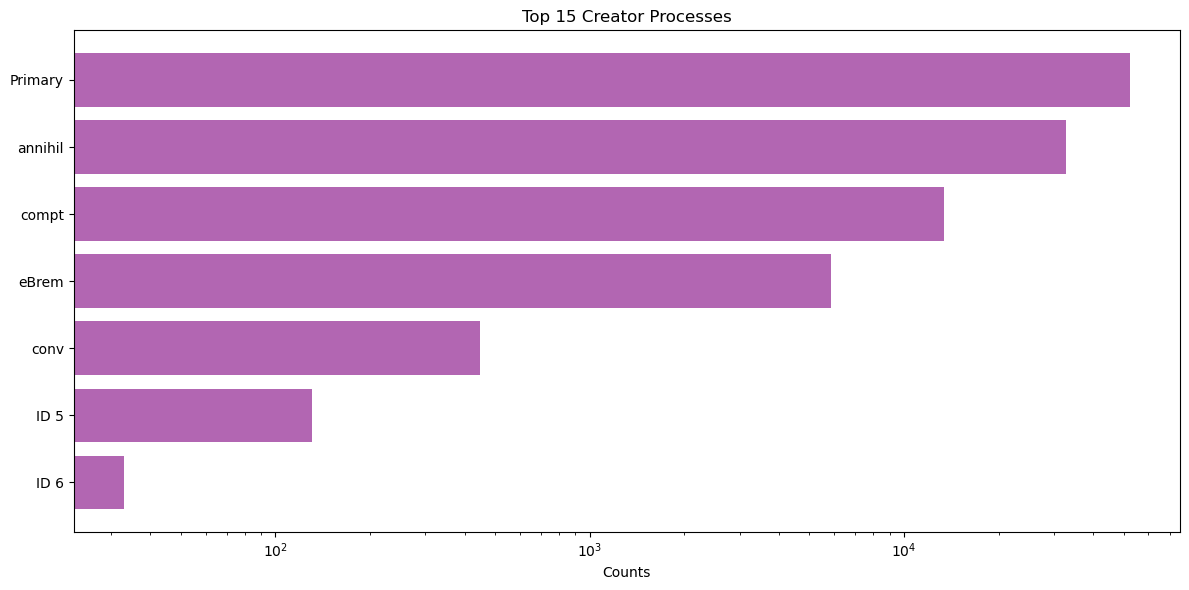

In [35]:
# 5. 物理过程分布
unique_procs, proc_counts = np.unique(flat_process, return_counts=True)
proc_labels = [process_map.get(pid, f"ID {pid}") for pid in unique_procs]

sorted_indices = np.argsort(proc_counts)[::-1]
sorted_counts = proc_counts[sorted_indices]
sorted_labels = np.array(proc_labels)[sorted_indices]

top_n = 15
if len(sorted_counts) > top_n:
    sorted_counts = sorted_counts[:top_n]
    sorted_labels = sorted_labels[:top_n]

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_counts)), sorted_counts, color="purple", alpha=0.6)
plt.yticks(range(len(sorted_counts)), sorted_labels)
plt.xlabel("Counts")
plt.title(f"Top {top_n} Creator Processes")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.tight_layout()
plt.show()


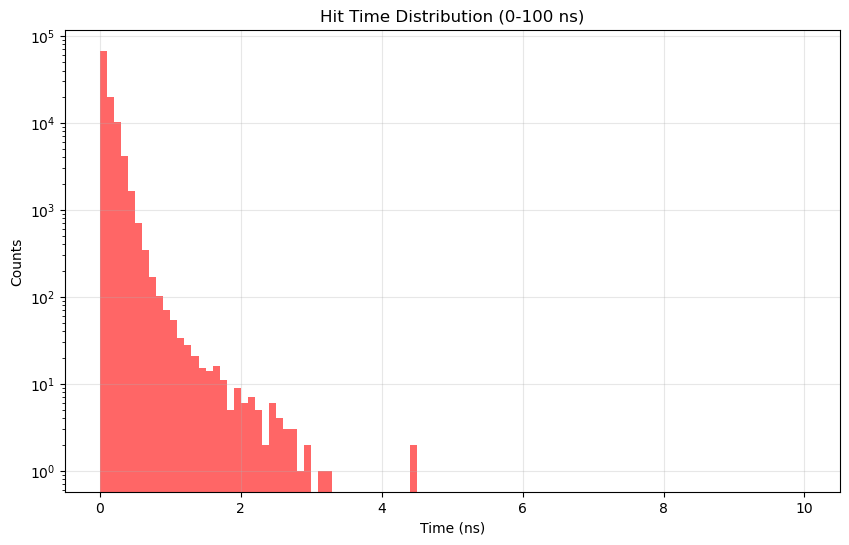

In [36]:
# 6. 时间分布
plt.figure(figsize=(10, 6))
plt.hist(flat_time, bins=100, range=(0, 10), color="red", alpha=0.6)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.title("Hit Time Distribution (0-100 ns)")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

# 每个事件的能量沉积与物理过程贡献分析

In [75]:
# 1. 计算每个事件的总能量沉积
# 方法1: 使用 Awkward Array 直接从 data 获取
event_total_edep_ak = data["TotalEdep"]

# 方法2: 使用 DataFrame 按事件分组求和
event_edep_df = df_hits.groupby("EventID")["edep"].sum().reset_index()
event_edep_df.rename(columns={"edep": "total_edep"}, inplace=True)

print("前10个事件的能量沉积:")
print(event_edep_df.head(10))
print(f"\n平均每事件能量沉积: {event_edep_df['total_edep'].mean():.3f} MeV")
print(f"能量沉积标准差: {event_edep_df['total_edep'].std():.3f} MeV")

前10个事件的能量沉积:
   EventID  total_edep
0        0    0.246478
1        1    5.926113
2        2    3.357351
3        3    5.965484
4        4    5.845357
5        5    3.581856
6        6    0.595095
7        7    5.150830
8        8    2.138156
9        9    2.748943

平均每事件能量沉积: 4.301 MeV
能量沉积标准差: 2.477 MeV


In [60]:
# 2. 按物理过程分析每个事件的能量沉积贡献
# 为每个事件计算不同物理过程的能量贡献

# 使用 DataFrame 按事件和物理过程分组
process_contribution = df_hits.groupby(["EventID", "processID"])["edep"].sum().reset_index()
process_contribution.rename(columns={"edep": "edep_by_process"}, inplace=True)

# 添加过程名称
process_contribution["process_name"] = process_contribution["processID"].map(process_map)

# 透视表：每行是一个事件，每列是一个物理过程
process_pivot = process_contribution.pivot_table(index="EventID", columns="process_name", values="edep_by_process", fill_value=0)

print("\n不同物理过程的能量沉积贡献 (前10个事件):")
print(process_pivot.head(10))

# 统计各过程的总贡献
print("\n\n各物理过程的总能量贡献:")
total_by_process = process_contribution.groupby("process_name")["edep_by_process"].sum().sort_values(ascending=False)
print(total_by_process)
print(f"\n总能量沉积: {total_by_process.sum():.3f} MeV")


不同物理过程的能量沉积贡献 (前10个事件):
process_name   Primary   annihil     compt  conv    eBrem  eIoni  phot
EventID                                                               
0             0.246478  0.000000  0.000000   0.0  0.00000    0.0   0.0
1             5.926113  0.000000  0.000000   0.0  0.00000    0.0   0.0
2             2.846352  0.510999  0.000000   0.0  0.00000    0.0   0.0
3             4.773440  1.148133  0.043911   0.0  0.00000    0.0   0.0
4             3.150919  0.317634  1.606084   0.0  0.77072    0.0   0.0
5             1.339932  0.924607  1.317318   0.0  0.00000    0.0   0.0
6             0.595095  0.000000  0.000000   0.0  0.00000    0.0   0.0
7             5.150830  0.000000  0.000000   0.0  0.00000    0.0   0.0
8             1.116158  1.021998  0.000000   0.0  0.00000    0.0   0.0
9             2.237944  0.413896  0.097103   0.0  0.00000    0.0   0.0


各物理过程的总能量贡献:
process_name
Primary    1.856812e+06
annihil    1.767436e+05
compt      4.574540e+04
eBrem      2.925985e+04

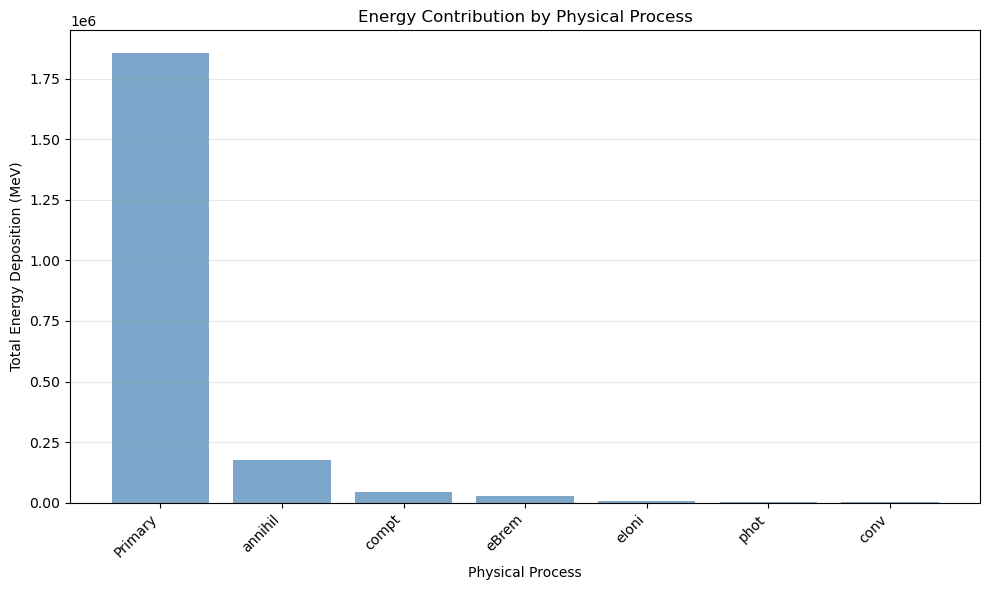

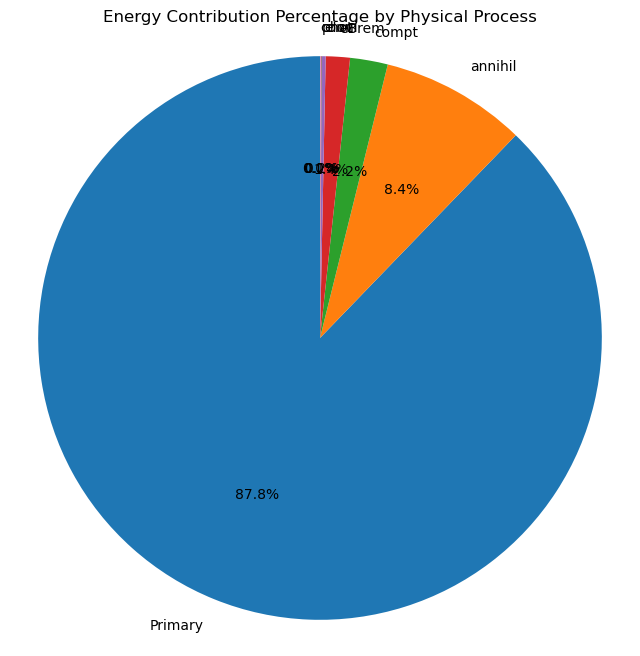

In [61]:
# 3. 可视化：物理过程的能量贡献占比
plt.figure(figsize=(10, 6))
plt.bar(range(len(total_by_process)), total_by_process.values, tick_label=total_by_process.index, alpha=0.7, color="steelblue")
plt.xlabel("Physical Process")
plt.ylabel("Total Energy Deposition (MeV)")
plt.title("Energy Contribution by Physical Process")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 饼图显示百分比
plt.figure(figsize=(8, 8))
plt.pie(total_by_process, labels=total_by_process.index, autopct="%1.1f%%", startangle=90)
plt.title("Energy Contribution Percentage by Physical Process")
plt.axis("equal")
plt.show()

In [62]:
# 4. 示例：查看特定事件的详细信息
example_event_id = 0

print(f"\n事件 {example_event_id} 的详细分析:")
print("=" * 60)

# 从 awkward array 获取
event_data = data[example_event_id]
print(f"总能量沉积: {event_data['TotalEdep']:.4f} MeV")
print(f"Hit 数量: {event_data['HitCount']}")

# 从 DataFrame 获取该事件的所有 Hit
event_hits = df_hits[df_hits["EventID"] == example_event_id]
print(f"\nHit 详情:")
print(event_hits[["edep", "pdg", "processID", "posX", "posY", "posZ"]])

# 该事件的物理过程贡献
event_process = process_contribution[process_contribution["EventID"] == example_event_id]
print(f"\n物理过程能量贡献:")
print(event_process[["process_name", "edep_by_process"]].sort_values("edep_by_process", ascending=False))


事件 0 的详细分析:
总能量沉积: 0.2465 MeV
Hit 数量: 1

Hit 详情:
       edep  pdg  processID   posX        posY       posZ
0  0.246478   11          0  243.5 -217.280024 -63.638601

物理过程能量贡献:
  process_name  edep_by_process
0      Primary         0.246478


## Primary 过程的物理含义分析

在 Geant4 中，`Primary` (processID=0) 并不代表某个具体的物理过程，而是标记**初级粒子**直接造成的能量沉积。

初级粒子损失能量的主要机制取决于粒子类型：
- **电子/正电子 (e⁻/e⁺)**: 主要通过**电离损失** (ionization) 和**韧致辐射** (bremsstrahlung)
- **光子 (γ)**: 通过**光电效应** (photoelectric)、**康普顿散射** (Compton) 或**对产生** (pair production)
- **重带电粒子**: 主要通过电离损失

让我们分析一下 Primary 标记的 Hit 中粒子的类型分布:

In [65]:
# 5. 分析 Primary 标记的 Hit 中粒子类型分布
# 筛选出 processID = 0 (Primary) 的所有 Hit
primary_hits_only = df_hits[df_hits["processID"] == 0].copy()

print(f"Primary 过程的 Hit 统计:")
print(f"总数: {len(primary_hits_only)} ({len(primary_hits_only) / len(df_hits) * 100:.1f}%)")
print(f"总能量: {primary_hits_only['edep'].sum():.3f} MeV ({primary_hits_only['edep'].sum() / df_hits['edep'].sum() * 100:.1f}%)")

# 按粒子类型统计
pdg_names = {22: "Gamma (γ)", 11: "Electron (e⁻)", -11: "Positron (e⁺)", 13: "Muon (μ⁻)", -13: "Anti-muon (μ⁺)", 2112: "Neutron", 2212: "Proton"}

primary_by_pdg = primary_hits_only.groupby("pdg").agg({"edep": ["count", "sum", "mean"]}).round(4)

primary_by_pdg.columns = ["Hit_Count", "Total_Energy (MeV)", "Mean_Energy (MeV)"]
primary_by_pdg["Percentage"] = (primary_by_pdg["Total_Energy (MeV)"] / primary_by_pdg["Total_Energy (MeV)"].sum() * 100).round(2)
primary_by_pdg.index = primary_by_pdg.index.map(lambda x: f"{pdg_names.get(x, f'PDG {x}')} ({x})")

print("\nPrimary 过程中不同粒子类型的能量沉积:")
print("=" * 80)
print(primary_by_pdg.sort_values("Total_Energy (MeV)", ascending=False))
print("=" * 80)

Primary 过程的 Hit 统计:
总数: 520906 (48.8%)
总能量: 1856811.978 MeV (87.8%)

Primary 过程中不同粒子类型的能量沉积:
                     Hit_Count  Total_Energy (MeV)  Mean_Energy (MeV)  \
pdg                                                                     
Positron (e⁺) (-11)     474029        1.801065e+06             3.7995   
Electron (e⁻) (11)       46877        5.574709e+04             1.1892   

                     Percentage  
pdg                              
Positron (e⁺) (-11)        97.0  
Electron (e⁻) (11)          3.0  


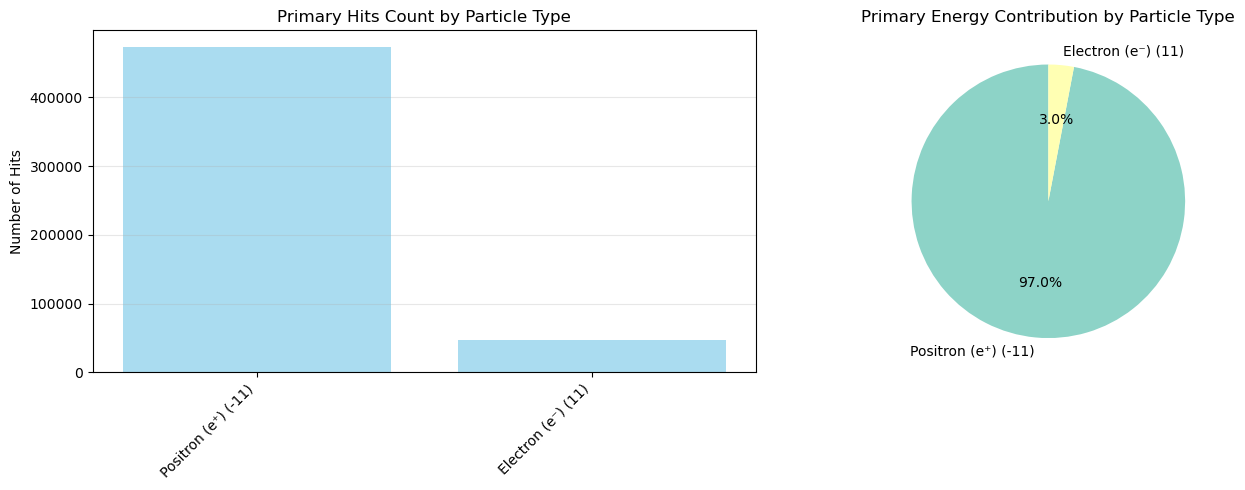

In [69]:
# 6. 可视化 Primary 过程中粒子类型的贡献
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图: Hit 数量分布
particle_counts = primary_by_pdg["Hit_Count"].sort_values(ascending=False)
ax1.bar(range(len(particle_counts)), particle_counts.values, color="skyblue", alpha=0.7)
ax1.set_xticks(range(len(particle_counts)))
ax1.set_xticklabels(particle_counts.index, rotation=45, ha="right")
ax1.set_ylabel("Number of Hits")
ax1.set_title("Primary Hits Count by Particle Type")
ax1.grid(True, axis="y", alpha=0.3)

# 右图: 能量贡献饼图
energy_contrib = primary_by_pdg["Total_Energy (MeV)"].sort_values(ascending=False)
colors = plt.cm.Set3(range(len(energy_contrib)))
ax2.pie(energy_contrib, labels=energy_contrib.index, autopct="%1.1f%%", startangle=90, colors=colors)
ax2.set_title("Primary Energy Contribution by Particle Type")

plt.tight_layout()
plt.show()


初级电子/正电子的能量损失特征:
总 Hit 数: 520906
总沉积能量: 1856811.978 MeV
平均沉积能量: 3.5646 MeV/hit
平均动能: 1.9770 MeV

动能范围: 0.0000 - 4.0000 MeV


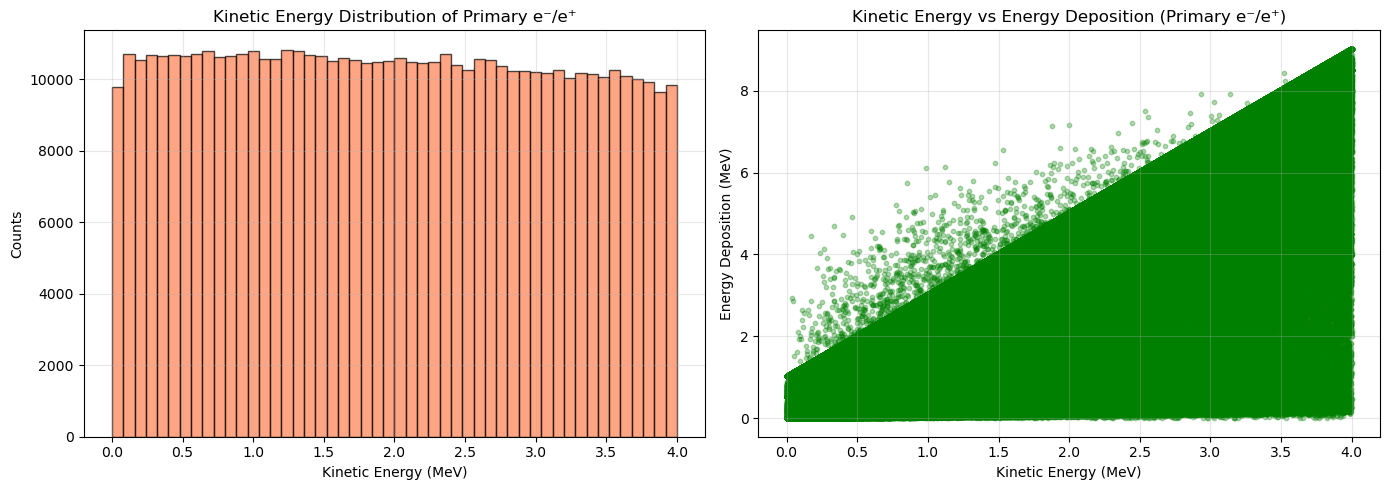


物理解释:
Primary 标记的能量沉积主要来自:
1. 电子/正电子: 通过【电离损失】(ionization) 逐渐损失能量
   - dE/dx ∝ 1/β² (低能时能量损失率更高)
   - 在探测器材料中连续慢化，每次相互作用沉积少量能量
2. 低能电子的特点:
   - 能量越低，单位路径能量损失越大
   - 最终可能完全停止在探测器中
3. processID=0 说明这是【初级粒子本身】的能量沉积
   而不是它产生的次级粒子 (如韧致辐射光子、散射电子等)


In [70]:
# 7. 分析初级电子/正电子的能量损失机制
# Primary 标记的 Hit 主要是初级粒子通过电离损失能量
# 让我们查看这些粒子的动能分布，了解它们在沉积能量时的状态

e_primary = primary_hits_only[(primary_hits_only["pdg"] == 11) | (primary_hits_only["pdg"] == -11)]

print(f"\n初级电子/正电子的能量损失特征:")
print(f"总 Hit 数: {len(e_primary)}")
print(f"总沉积能量: {e_primary['edep'].sum():.3f} MeV")
print(f"平均沉积能量: {e_primary['edep'].mean():.4f} MeV/hit")
print(f"平均动能: {e_primary['kineticEnergy'].mean():.4f} MeV")
print(f"\n动能范围: {e_primary['kineticEnergy'].min():.4f} - {e_primary['kineticEnergy'].max():.4f} MeV")

# 绘制动能 vs 沉积能量的关系
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图: 动能分布
axes[0].hist(e_primary["kineticEnergy"], bins=50, color="coral", alpha=0.7, edgecolor="black")
axes[0].set_xlabel("Kinetic Energy (MeV)")
axes[0].set_ylabel("Counts")
axes[0].set_title("Kinetic Energy Distribution of Primary e⁻/e⁺")
axes[0].grid(True, alpha=0.3)

# 右图: 动能 vs 沉积能量
axes[1].scatter(e_primary["kineticEnergy"], e_primary["edep"], alpha=0.3, s=10, c="green")
axes[1].set_xlabel("Kinetic Energy (MeV)")
axes[1].set_ylabel("Energy Deposition (MeV)")
axes[1].set_title("Kinetic Energy vs Energy Deposition (Primary e⁻/e⁺)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n物理解释:")
print("=" * 80)
print("Primary 标记的能量沉积主要来自:")
print("1. 电子/正电子: 通过【电离损失】(ionization) 逐渐损失能量")
print("   - dE/dx ∝ 1/β² (低能时能量损失率更高)")
print("   - 在探测器材料中连续慢化，每次相互作用沉积少量能量")
print("2. 低能电子的特点:")
print("   - 能量越低，单位路径能量损失越大")
print("   - 最终可能完全停止在探测器中")
print("3. processID=0 说明这是【初级粒子本身】的能量沉积")
print("   而不是它产生的次级粒子 (如韧致辐射光子、散射电子等)")
print("=" * 80)

# 基于事件级别的粒子分析

接下来我们按事件(Event)为单位，分析每个事件中不同粒子的贡献，包括：
- 不同粒子类型的能量沉积
- 不同粒子的Hit数量
- 径迹长度统计
- 粒子能谱分析

In [ ]:
# 1. 计算每个事件中不同粒子类型的能量沉积
# 为 df_hits 添加粒子名称列
pdg_name_map = {22: "Gamma", 11: "Electron", -11: "Positron", 13: "Muon-", -13: "Muon+", 2112: "Neutron", 2212: "Proton"}
df_hits["particle_name"] = df_hits["pdg"].map(lambda x: pdg_name_map.get(x, f"PDG_{x}"))

# 按事件和粒子类型分组统计
event_particle_stats = (
    df_hits.groupby(["EventID", "particle_name"])
    .agg({
        "edep": ["sum", "mean", "count"],  # 总能量、平均能量、Hit数
        "kineticEnergy": ["mean", "max", "min"],  # 动能统计
    })
    .reset_index()
)

# 简化列名
event_particle_stats.columns = ["EventID", "Particle", "Total_Edep", "Mean_Edep", "Hit_Count", "Mean_KE", "Max_KE", "Min_KE"]

print("事件-粒子级别统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n数据形状: {event_particle_stats.shape}")
print(f"涉及的粒子类型: {event_particle_stats['Particle'].unique()}")

事件-粒子级别统计 (前20行):
    EventID  Particle  Total_Edep  Mean_Edep  Hit_Count   Mean_KE    Max_KE  \
0         0  Electron    0.246478   0.246478          1  0.331854  0.331854   
1         1  Positron    5.926113   5.926113          1  2.568682  2.568682   
2         2     Gamma    0.510999   0.510999          1  0.108472  0.108472   
3         2  Positron    2.846352   2.846352          1  1.167677  1.167677   
4         3  Electron    0.043911   0.043911          1  0.043911  0.043911   
5         3     Gamma    1.148133   0.574066          2  0.247107  0.296551   
6         3  Positron    4.773440   4.773440          1  2.471743  2.471743   
7         4  Electron    1.606084   1.606084          1  0.193364  0.193364   
8         4     Gamma    1.088354   0.362785          3  0.343929  0.391653   
9         4  Positron    3.150919   3.150919          1  2.920815  2.920815   
10        5  Electron    1.317318   1.317318          1  0.056248  0.056248   
11        5     Gamma    0.924607 

: 

In [72]:
# 2. 计算每个事件中每种粒子的径迹长度 (Track Length)
# 径迹长度可以通过相邻Hit之间的距离估算
# 注意：这是一个粗略估算，因为我们没有完整的径迹信息


def calculate_track_length(event_hits):
    """计算一个事件中所有Hit的总路径长度"""
    if len(event_hits) <= 1:
        return 0.0

    # 按时间排序（假设时间顺序反映径迹顺序）
    event_hits = event_hits.sort_values("time")

    # 计算相邻Hit之间的距离
    dx = event_hits["posX"].diff()
    dy = event_hits["posY"].diff()
    dz = event_hits["posZ"].diff()

    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    return distances.sum()


# 计算每个事件中每种粒子的径迹长度
track_lengths = []

for (event_id, particle), group in df_hits.groupby(["EventID", "particle_name"]):
    track_length = calculate_track_length(group)
    track_lengths.append({"EventID": event_id, "Particle": particle, "Track_Length_mm": track_length})

df_track_lengths = pd.DataFrame(track_lengths)

# 合并到事件-粒子统计中
event_particle_stats = event_particle_stats.merge(df_track_lengths, on=["EventID", "Particle"], how="left")

print("添加径迹长度后的统计 (前20行):")
print(event_particle_stats.head(20))
print(f"\n各粒子的平均径迹长度:")
print(event_particle_stats.groupby("Particle")["Track_Length_mm"].mean().sort_values(ascending=False))

KeyboardInterrupt: 

In [ ]:
# 3. 创建事件级别的汇总表：将不同粒子的数据展开成列
# 使用透视表将每种粒子作为单独的列
event_summary = event_particle_stats.pivot_table(index="EventID", columns="Particle", values=["Total_Edep", "Hit_Count", "Track_Length_mm"], fill_value=0)

# 简化多层列名
event_summary.columns = [f"{particle}_{metric}" for metric, particle in event_summary.columns]
event_summary.reset_index(inplace=True)

# 添加事件总能量和总Hit数
event_summary["Total_Event_Edep"] = event_edep_df["total_edep"].values
event_summary["Total_Hit_Count"] = df_hits.groupby("EventID").size().values

print("事件级别汇总表 (前10个事件):")
print(event_summary.head(10))
print(f"\n汇总表形状: {event_summary.shape}")
print(f"\n列名: {list(event_summary.columns)}")

In [ ]:
# 4. 统计分析：各粒子在所有事件中的贡献
particle_overall_stats = (
    event_particle_stats.groupby("Particle")
    .agg({
        "Total_Edep": ["sum", "mean", "std"],
        "Hit_Count": ["sum", "mean", "std"],
        "Track_Length_mm": ["mean", "std", "max"],
        "Mean_KE": "mean",
        "EventID": "count",  # 出现在多少个事件中
    })
    .round(4)
)

particle_overall_stats.columns = [
    "Total_Energy",
    "Mean_Energy_per_Event",
    "Std_Energy",
    "Total_Hits",
    "Mean_Hits_per_Event",
    "Std_Hits",
    "Mean_Track_Length",
    "Std_Track_Length",
    "Max_Track_Length",
    "Mean_Kinetic_Energy",
    "Event_Count",
]

# 添加能量占比
total_energy = particle_overall_stats["Total_Energy"].sum()
particle_overall_stats["Energy_Percentage"] = (particle_overall_stats["Total_Energy"] / total_energy * 100).round(2)

# 按总能量排序
particle_overall_stats = particle_overall_stats.sort_values("Total_Energy", ascending=False)

print("各粒子类型的整体统计:")
print("=" * 100)
print(particle_overall_stats)
print("=" * 100)

In [ ]:
# 5. 可视化：不同粒子的事件级别能量分布
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 5.1 不同粒子的能量贡献对比（柱状图）
ax = axes[0, 0]
particles = particle_overall_stats.index
energies = particle_overall_stats["Total_Energy"]
colors_palette = plt.cm.tab10(range(len(particles)))
ax.bar(range(len(particles)), energies, color=colors_palette, alpha=0.7, edgecolor="black")
ax.set_xticks(range(len(particles)))
ax.set_xticklabels(particles, rotation=45, ha="right")
ax.set_ylabel("Total Energy Deposition (MeV)")
ax.set_title("Total Energy Contribution by Particle Type")
ax.set_yscale("log")
ax.grid(True, axis="y", alpha=0.3)

# 5.2 不同粒子的每事件平均能量沉积
ax = axes[0, 1]
mean_energies = particle_overall_stats["Mean_Energy_per_Event"]
std_energies = particle_overall_stats["Std_Energy"]
ax.bar(range(len(particles)), mean_energies, yerr=std_energies, color=colors_palette, alpha=0.7, edgecolor="black", capsize=5)
ax.set_xticks(range(len(particles)))
ax.set_xticklabels(particles, rotation=45, ha="right")
ax.set_ylabel("Mean Energy per Event (MeV)")
ax.set_title("Average Energy Deposition per Event by Particle")
ax.grid(True, axis="y", alpha=0.3)

# 5.3 不同粒子的Hit数量对比
ax = axes[1, 0]
hit_counts = particle_overall_stats["Total_Hits"]
ax.bar(range(len(particles)), hit_counts, color=colors_palette, alpha=0.7, edgecolor="black")
ax.set_xticks(range(len(particles)))
ax.set_xticklabels(particles, rotation=45, ha="right")
ax.set_ylabel("Total Hit Count")
ax.set_title("Total Hit Count by Particle Type")
ax.set_yscale("log")
ax.grid(True, axis="y", alpha=0.3)

# 5.4 不同粒子的平均径迹长度
ax = axes[1, 1]
track_lengths = particle_overall_stats["Mean_Track_Length"]
ax.bar(range(len(particles)), track_lengths, color=colors_palette, alpha=0.7, edgecolor="black")
ax.set_xticks(range(len(particles)))
ax.set_xticklabels(particles, rotation=45, ha="right")
ax.set_ylabel("Mean Track Length (mm)")
ax.set_title("Average Track Length by Particle Type")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 6. 示例：详细查看某个事件的粒子组成
example_event = 100  # 选择一个事件

print(f"\n{'=' * 80}")
print(f"事件 {example_event} 的详细粒子分析")
print(f"{'=' * 80}\n")

# 获取该事件的所有粒子信息
event_particles = event_particle_stats[event_particle_stats["EventID"] == example_event]

print("粒子组成:")
print(event_particles[["Particle", "Total_Edep", "Hit_Count", "Track_Length_mm", "Mean_KE", "Max_KE"]].to_string(index=False))

# 可视化该事件的粒子贡献
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 能量贡献饼图
particles_in_event = event_particles["Particle"]
energies_in_event = event_particles["Total_Edep"]
ax1.pie(energies_in_event, labels=particles_in_event, autopct="%1.1f%%", startangle=90)
ax1.set_title(f"Event {example_event}: Energy Contribution by Particle")

# Hit数量柱状图
ax2.bar(range(len(particles_in_event)), event_particles["Hit_Count"], tick_label=particles_in_event, color="steelblue", alpha=0.7)
ax2.set_ylabel("Hit Count")
ax2.set_xlabel("Particle Type")
ax2.set_title(f"Event {example_event}: Hit Count by Particle")
ax2.tick_params(axis="x", rotation=45)
ax2.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n事件总能量: {event_summary[event_summary['EventID'] == example_event]['Total_Event_Edep'].values[0]:.4f} MeV")
print(f"事件总Hit数: {event_summary[event_summary['EventID'] == example_event]['Total_Hit_Count'].values[0]}")

In [ ]:
# 7. 粒子能量谱分析：每个事件中不同粒子的能量分布
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 为主要粒子类型绘制能量谱
main_particles = particle_overall_stats.index[:6]  # 选择前6种粒子

for idx, particle in enumerate(main_particles):
    ax = axes[idx]
    particle_data = event_particle_stats[event_particle_stats["Particle"] == particle]

    # 绘制该粒子在各事件中的能量分布
    energies = particle_data["Total_Edep"]

    ax.hist(energies, bins=50, alpha=0.7, color=plt.cm.tab10(idx), edgecolor="black")
    ax.set_xlabel("Energy Deposition (MeV)")
    ax.set_ylabel("Event Count")
    ax.set_title(f"{particle} Energy Distribution")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)

    # 添加统计信息
    mean_e = energies.mean()
    std_e = energies.std()
    ax.axvline(mean_e, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_e:.3f} MeV")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 8. 粒子相关性分析：正电子和电子在同一事件中的能量关系
# 提取正电子和电子的事件级数据
positron_data = event_particle_stats[event_particle_stats["Particle"] == "Positron"][["EventID", "Total_Edep"]]
electron_data = event_particle_stats[event_particle_stats["Particle"] == "Electron"][["EventID", "Total_Edep"]]

positron_data = positron_data.rename(columns={"Total_Edep": "Positron_Edep"})
electron_data = electron_data.rename(columns={"Total_Edep": "Electron_Edep"})

# 合并数据
e_correlation = pd.merge(positron_data, electron_data, on="EventID", how="outer").fillna(0)

print("正电子-电子能量相关性分析:")
print(f"有正电子沉积的事件数: {(e_correlation['Positron_Edep'] > 0).sum()}")
print(f"有电子沉积的事件数: {(e_correlation['Electron_Edep'] > 0).sum()}")
print(f"同时有两者的事件数: {((e_correlation['Positron_Edep'] > 0) & (e_correlation['Electron_Edep'] > 0)).sum()}")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 散点图：正电子 vs 电子能量
ax = axes[0]
mask = (e_correlation["Positron_Edep"] > 0) & (e_correlation["Electron_Edep"] > 0)
ax.scatter(e_correlation[mask]["Positron_Edep"], e_correlation[mask]["Electron_Edep"], alpha=0.5, s=20, c="purple")
ax.set_xlabel("Positron Energy Deposition (MeV)")
ax.set_ylabel("Electron Energy Deposition (MeV)")
ax.set_title("Positron vs Electron Energy in Same Events")
ax.grid(True, alpha=0.3)
ax.set_xscale("log")
ax.set_yscale("log")

# 2D直方图
ax = axes[1]
ax.hist2d(e_correlation[mask]["Positron_Edep"], e_correlation[mask]["Electron_Edep"], bins=50, cmap="viridis", cmin=1)
ax.set_xlabel("Positron Energy Deposition (MeV)")
ax.set_ylabel("Electron Energy Deposition (MeV)")
ax.set_title("Positron vs Electron Energy Density")
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(ax.collections[0], ax=ax, label="Event Count")

plt.tight_layout()
plt.show()